In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2
import pandas as pd
import pickle
import random
import math
import os
from sklearn import metrics
from torchviz import make_dot

"""Referenced PyTorch documentation"""

'Referenced PyTorch documentation'

# Main Body

In [19]:
class DatasetCIFAR(Dataset):
    def __init__(self, annotations_file : str, img_file : str, transform = None) -> object: 
    # initialize dataset class
        annotations = np.load(annotations_file)
        self.img_labels = F.one_hot(torch.from_numpy(annotations), num_classes=10) # Convert to one-hot-encode
        self.img_data = torch.from_numpy(np.load(img_file))

        # Normalize the data
        self.img_data = torch.div(self.img_data, 255)
        
        # Permute the data dimensions to match PyTorch convention, and correctly orient image
        self.img_data = self.img_data.permute(0, 3, 2, 1)
        # self.img_data = self.img_data.permute(0, 3, 1, 2) # Testing alternative permute

        self.transform = transform

    def __len__(self):
    #return length of the total dataset 
        return len(self.img_labels)

    def __getitem__(self, idx : int): 
        # return data and label with index idx
        image = self.img_data[idx]
        label = self.img_labels[idx]
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

class CifarClassifier(torch.nn.Module):
    """
    Input images are 32 x 32 color images
    10 classes

    Layers:
    1. Convolutional layer1: 16 5 x 5 filters.  No zero padding with the stride as 1. 
    2. Max pooling layer1: The pooling area is 2 x 2 with the stride as 2. 
    3. Convolutional layer2: 32 5 x 5 filters.  No zero padding with the stride as 1. 
    4. Max pooling layer2: The pooling area is 2 x 2 with the stride as 2. 
    5. Convolutional layer3: 64 3 x 3 filters.  No zero padding with the stride as 1.
        - Note that ReLU activation is applied to all convolutional maps. 
    """
    def __init__(self):
        super(CifarClassifier, self).__init__()
        # Convolutional Layers
        self.batch_norm_0 = nn.BatchNorm2d(num_features=3)
        self.conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.batch_norm_1 = nn.BatchNorm2d(num_features = 16)
        self.conv_layer_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.batch_norm_2 = nn.BatchNorm2d(num_features = 32)
        self.conv_layer_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batch_norm_3 = nn.BatchNorm2d(num_features = 64)

        # Fully connected layer (500 nodes)
        self.fc1 = nn.Linear(in_features=64 * 3 * 3, out_features=500)
        self.dropout_fc1 = nn.Dropout(p=0.1)

        # Output layer (10 nodes)
        self.fc2 = nn.Linear(in_features = 500, out_features = 10)
    
    def forward(self, x):
        # Forward propagation

        # print("input shape:", x.shape) # TODO: Remove
        
        # print("Input:", x[0][0]) # TODO: Remove

        x = self.batch_norm_0(x)

        # Convolutional layer1: 16 5 x 5 filters.  No zero padding with the stride as 1.
        # Convolutional layer 1 dim is 28x28
        x = self.conv_layer_1(x)
        # print("After conv1 shape:", x.shape) # TODO: Remove
        x = self.batch_norm_1(x)
        x = F.relu(x)
        

        # Max pooling layer1: The pooling area is 2 x 2 with the stride as 2.
        # Max pooling layer 1 dim is 14x14
        x = F.max_pool2d(x, (2, 2), 2)
        # print("After pooling 1 shape:", x.shape) # TODO: Remove

        # Convolutional layer2: 32 5 x 5 filters.  No zero padding with the stride as 1.
        # Convolutional layer 2 dim is 10x10
        # x = F.relu(self.conv_layer_2(x))
        x = self.conv_layer_2(x)
        # print("After conv2 shape:", x.shape) # TODO: Remove
        x = self.batch_norm_2(x)
        x = F.relu(x)

        # Max pooling layer2: The pooling area is 2 x 2 with the stride as 2.
        # Max pooling layer 2 dim is 5x5
        x = F.max_pool2d(x, (2, 2), 2)
        # print("After pooling 2 shape:", x.shape) # TODO: Remove

        # Convolutional layer3: 64 3 x 3 filters.  No zero padding with the stride as 1.
        # Convolution layer 3 dim is 3x3
        # x = F.relu(self.conv_layer_3(x)) # TODO: Remove
        x = self.conv_layer_3(x)
        # print("After conv3 shape:", x.shape) # TODO: Remove
        x = self.batch_norm_3(x)
        x = F.relu(x)

        # Flatten x
        x = torch.flatten(x, start_dim = 1, end_dim = -1)
        # print("After flattening", x[0]) # TODO: Remove
        
        # print("before fc1 x shape:", x.shape) # TODO: Remove
        # Fully connected layer with 500 nodes
        x = F.relu(self.fc1(x))
        # print("After connected layer 1", x.shape) # TODO: Remove
        x = self.dropout_fc1(x)
        # Output layer with 10 nodes
        x = F.softmax(self.fc2(x), dim=-1)
        # print("Output:", x.shape) # TODO: Remove 

        return x

# Helper Functions
# Reference source: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
def train_one_epoch(epoch_index : int, model, train_dataloader : DataLoader, loss_func, optimizer, device : str = 'cpu'):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(train_dataloader):
        # Get the batch num
        batch_num = len(train_dataloader)
        # print("Batch number:", batch_num)
        
        # Get the inputs and labels from the data
        inputs, labels = data

        # Change the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # print("Labels:", labels) # TODO: Remove
        
        # Zero the gradients for every batch
        optimizer.zero_grad()

        # Make the predictions from the forward pass
        outputs = model(inputs)

        # print("Outputs type:", outputs.dtype) # TODO: Remove

        # print("outputs:", outputs) # TODO: Remove

        # Compute the loss
        loss = loss_func(outputs, labels.float())
        # print(f"I need to see this loss: {loss}")
        
        # Compute loss gradients using backward
        loss.backward()

        # Make adjustments to the learning weights
        optimizer.step()

        # Sum the losses and accuracies
        running_loss += loss.item()
        running_accuracy += calc_acc(outputs, labels)

        # if i % batch_num == batch_num - 1:
        #     # TODO: CHECK THIS OUT! Do some stuff
        #     last_loss = running_loss / batch_num # l
        #     print(f"Batch {i + 1} loss: {last_loss}")
        #     running_loss = 0
        
        # break # TODO: Remove

    avg_loss = running_loss / len(train_dataloader)
    avg_accuracy = running_accuracy / len(train_dataloader)

    return avg_loss, avg_accuracy
    
    
def CIFAR_train(model, train_dataloader : DataLoader, test_dataloader : DataLoader, loss_func, optimizer, device = 'cpu'):
    EPOCHS = 200

    avg_train_losses = []
    avg_train_accuracies = []

    avg_test_losses = []
    avg_test_accuracies = []

    best_test_accuracy = 0

    for epoch in range(EPOCHS):
        print(f"---Epoch {epoch + 1}---")
        # Ensure gradient tracking is on
        model.train(True)
        avg_train_loss, avg_train_accuracy = train_one_epoch(epoch, model, train_dataloader, loss_func, optimizer, device)

        # Set model to evaluation mode
        # TODO: Review what this does
        model.eval()

        # Get testing loss and testing accuracy
        running_test_loss = 0.0
        running_test_accuracy = 0.0
        with torch.no_grad(): # Disable gradient computation and reduce memory consumption.
            for i, test_data in enumerate(test_dataloader):
                test_inputs, test_labels = test_data

                # Change the device
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)
                
                # Calculate the test output
                test_outputs = model(test_inputs)

                # Calculate the test loss
                test_loss = loss_func(test_outputs, test_labels.float())
                running_test_loss += test_loss.item()
                
                # Calculate the test accuracy
                running_test_accuracy += calc_acc(test_outputs, test_labels)
        
        # Calculate the average test losses and accuracy
        avg_test_loss = running_test_loss / (i + 1)
        avg_test_accuracy = running_test_accuracy / (i + 1)

        # Append the losses and accuracies
        avg_train_losses.append(avg_train_loss)
        avg_train_accuracies.append(avg_train_accuracy)
        avg_test_losses.append(avg_test_loss)
        avg_test_accuracies.append(avg_test_accuracy)

        # Save the best model parameters
        if avg_test_accuracy > best_test_accuracy:
            best_test_accuracy = avg_test_accuracy
            torch.save(model.state_dict(), 'CIFAR_classifier.pth')
        
        # Print the per epoch losses and accuracies
        print(f"Loss:     | Train: {avg_train_loss:.5f} | Test: {avg_test_loss:.5f}")
        print(f"Accuracy: | Train: {avg_train_accuracy:.5f} | Test: {avg_test_accuracy:.5f}")
    
    stats = {
        'training' : {
            'losses' : avg_train_losses,
            'accuracies' : avg_train_accuracies
        },
        'testing' : {
            'losses' : avg_test_losses,
            'accuracies' : avg_test_accuracies
        },
        'epochs' : np.arange(0, EPOCHS)
    }

    return stats

def CIFAR_test(data_path : str, label_path : str, model_param_path : str):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    dataset = DatasetCIFAR(annotations_file=label_path, img_file=data_path)

    # Load the dataset into dataloader
    dataloader_params = {
        'batch_size': len(dataset),
        'shuffle': False,
        'num_workers': 1
    }
    dataloader = DataLoader(dataset, **dataloader_params)

    # Load the model parameters
    model = CifarClassifier()
    model.load_state_dict(torch.load(model_param_path, map_location=device))

    inputs, labels = next(iter(dataloader))

    # Get outputs from forward propagation
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)

    accuracy = calc_acc(prediction=outputs, actual=labels)

    # # TODO: Remove
    # print('inputs shape:', inputs.shape)
    # print('outputs shape:', outputs.shape)
    # print('labels shape:', labels.shape)

    print(f"Final Test Accuracy:{accuracy}")

    # Call the confusion matrix
    create_conf_mat(outputs, labels)

    # Visualize the weights
    conv1_filters = model.conv_layer_1.weight.data

    plot_filters(conv1_filters)    

    return accuracy

def calc_acc(prediction, actual):
    # Calculate accuracy
    accuracy = torch.sum(torch.argmax(prediction, 1) == torch.argmax(actual, 1))/actual.shape[0]
    return accuracy.item()

def one_hot_decode(tensor):
    return torch.argmax(tensor, dim=-1).numpy()

def create_conf_mat(prediction, actual):
    DISPLAY_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']
    my_pred = one_hot_decode(prediction)
    my_act = one_hot_decode(actual)

    cm_fig = plt.figure()
    confusion_matrix = metrics.confusion_matrix(y_pred=my_pred, y_true=my_act)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                                display_labels=DISPLAY_LABELS)
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout()
    plt.savefig('./plots/class_confusion_matrix.jpg')

def line_plot(xvals, xlab : str, ylab: str, yvals0, ylab0 : str, dir : str, yvals1 = None, ylab1 : str = None):
    """
    line_plot Creates a line plot of the xvals vs yvals
    """
    fig = plt.figure()
    
    if yvals1:
        plt.plot(xvals, yvals0, label = ylab0)
        plt.plot(xvals, yvals1, label = ylab1)
        plt.legend()
    else:
        plt.plot(xvals, yvals0)
    
    plt.title(f"{ylab} vs {xlab}")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    file_path = os.path.join(dir, f"{ylab.replace(' ', '_')}_vs_{xlab.replace(' ', '_')}_plot.png")
    plt.savefig(file_path)

def plot_performance(stats : dict):
    plot_dir = './plots'
    # line_plot(
    #     xvals0=stats['epochs'],
    #     yvals=stats['training']['losses'],
    #     xlabel="Epochs",
    #     ylabel="Average Training Loss"
    # )
    print(stats['training']['losses'])
    # print("Epochs device:", stats['epochs'].device)

    # Training and testing loss over epochs plot 
    line_plot(
        xvals = stats['epochs'],
        xlab='Epochs',
        ylab='Average Loss',
        yvals0=stats['training']['losses'],
        ylab0='Training Losses',
        yvals1=stats['testing']['losses'],
        ylab1='Testing Losses',
        dir = plot_dir
    )

    # Training and testing accuracies over epochs plot
    line_plot(
        xvals = stats['epochs'],
        xlab='Epochs',
        ylab='Average Accuracy',
        yvals0=stats['training']['accuracies'],
        ylab0='Training Accuracies',
        yvals1=stats['testing']['accuracies'],
        ylab1='Testing Accuracies',
        dir = plot_dir
    )

def plot_filters(filters):
    plot_dir = './plots'
    NUM_ROWS = 4
    num_cols = len(filters) // NUM_ROWS
    fig = plt.figure()
    print(f"Filter num: {len(filters)}")

    # Set up the figure with the rows and columns
    fig, axes = plt.subplots(nrows=NUM_ROWS, ncols=num_cols,figsize = (8,8))

    # Plot each filter
    for i in range(len(filters)):
        row = i // num_cols  # Integer division to determine the row
        col = i % num_cols   # Modulus to determine the column
        ax = axes[row, col]

        one_filter = filters[i]

        # Normalize the filter
        one_filter = (one_filter - one_filter.min()) / (one_filter.max() - one_filter.min())

        # ax.imshow(filters[i], cmap='gray')  # Plot the filter in grayscale
        ax.imshow(one_filter.permute(1,2,0), cmap='gray')  # Plot the filter in grayscale
        ax.set_title(f'Filter {i+1}', fontsize=10)
        ax.axis('off')  # Hide the axes
        plt.savefig(os.path.join(plot_dir, 'filters.png'))

    plt.show()

def visualize_dataset_labels(annotations_file : str, img_file : str):
    dataset = DatasetCIFAR(annotations_file=annotations_file, img_file=img_file)
    labels_found = [False]*9
    i = 30
    while False in labels_found and i < len(dataset):
        img, lab = dataset[i]
        decoded_lab = one_hot_decode(lab)
        
        fig = plt.figure()
        plt.title(f'Label {decoded_lab} associated image:')
        plt.imshow(img.permute(1,2,0))

        labels_found[decoded_lab-1] = True
        i += 1

def visualize_model(annotations_file : str, img_file : str, model_param_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    dataset = DatasetCIFAR(annotations_file=annotations_file, img_file=img_file)

    # Load the dataset into dataloader
    dataloader_params = {
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 1
    }
    dataloader = DataLoader(dataset, **dataloader_params)

    # Load the model parameters
    model = CifarClassifier()
    model.load_state_dict(torch.load(model_param_path, map_location=device))

    inputs, labels = next(iter(dataloader))

    outputs = model(inputs)
    # Source for visualization: https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch
    os.chdir('./plots')
    make_dot(outputs, params=dict(list(model.named_parameters()))).render("cnn_torchviz", format="png")
    os.chdir('../')
    print(os.getcwd())

    
# def calc_mean_std(dataloader : DataLoader):
#     ####### COMPUTE MEAN / STD

#     # placeholders
#     psum = torch.tensor([0.0, 0.0, 0.0])
#     psum_sq = torch.tensor([0.0, 0.0, 0.0])

#     # loop through images
#     for data in range(dataloader):
#         psum += data.sum(axis=[0, 2, 3])
#         psum_sq += (data**2).sum(axis=[0, 2, 3])
    
#     ####### FINAL CALCULATIONS

#     # pixel count
#     count = len(dataloader) * image_size * image_size

#     # mean and std
#     total_mean = psum / count
#     total_var = (psum_sq / count) - (total_mean**2)
#     total_std = torch.sqrt(total_var)

#     # output
#     print("mean: " + str(total_mean))
#     print("std:  " + str(total_std))

In [20]:
# Define Constants
data_dir = './data'
training_data_path = os.path.join(data_dir, 'training_data.npy')
training_label_path = os.path.join(data_dir, 'training_label.npy')
test_data_path = os.path.join(data_dir, 'test_data.npy')
test_label_path = os.path.join(data_dir,'test_label.npy')


In [21]:
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5)
])

# Load the datasets
training_dataset = DatasetCIFAR(annotations_file=training_label_path, img_file=training_data_path, transform=transform)
test_dataset = DatasetCIFAR(annotations_file=test_label_path, img_file=test_data_path, transform=transform)

# Define the parameters
dataloader_params = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 1
}

# Create the dataloaders
train_dataloader = DataLoader(training_dataset, **dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)

# Define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the model
model = CifarClassifier()
model = model.to(device)

# Define the loss function
# optimizer = torch.optim.SGD(model.parameters(), lr=0.006, momentum = 0.9, weight_decay=5e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.006, momentum = 0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

print(f"Device: {device}")

# # Visualize image
# figure = plt.figure()
# img, label = training_dataset[100]
# plt.imshow(img.permute(1,2,0), cmap='gray')
# # plt.imshow(img, cmap='gray')

Device: cpu


In [22]:
model_stats = CIFAR_train(model, train_dataloader, test_dataloader, loss_func, optimizer, device)

---Epoch 1---
Loss:     | Train: 2.18172 | Test: 2.09117
Accuracy: | Train: 0.27388 | Test: 0.38548
---Epoch 2---


KeyboardInterrupt: 

In [ ]:
plot_performance(model_stats)

NameError: name 'model_stats' is not defined

Final Test Accuracy:0.7283999919891357
Filter num: 16


<Figure size 640x480 with 0 Axes>

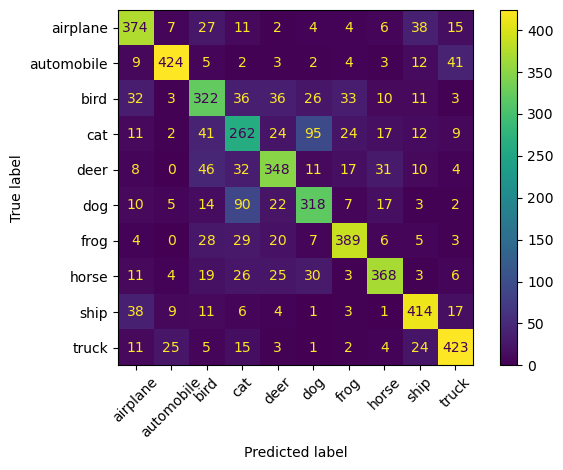

<Figure size 640x480 with 0 Axes>

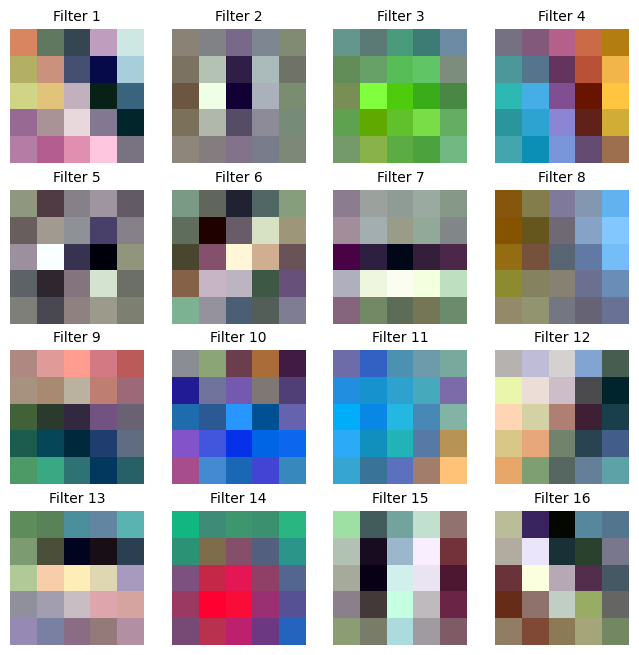

0.7283999919891357

In [ ]:
#Test Dataset
CIFAR_test(data_path=test_data_path, label_path=test_label_path, model_param_path='CIFAR_classifier.pth')

In [ ]:
visualize_model(annotations_file=test_label_path, img_file=test_data_path, model_param_path='CIFAR_classifier.pth')

/home/philip/Dropbox/S2024/ecse4850/pa/CNN-image-classifier
